# PHYSLITE Jets

A nice thing about PHYSLITE the data is written with corrections - so even when you access them with `EventLoop` it can be done very fast (applying corrections is amazingly expensive). There are two demos here, both the same query. The first runs against ServiceX and the second against a local file.

## Using the ServiceX Backend

A standard set of includes.

In [1]:
from servicex import ignore_cache
from func_adl_servicex_xaodr22 import calib_tools, SXDSAtlasxAODR22

import awkward as ak
import matplotlib.pyplot as plt

Lets setup a query using the first 20 files of the dataset. We'll limit the number of files. The `calib_tools` lets the backend know that it should not be re-running calibrations on this data and that default names for jets are things like `AnalysisJets`.

Note the backend is `atlasr22-testing-1`:

* The production backend can't do this yet (see the PR)
* At the time this was written (2023-10-23), `testing-1` was configured to run these queries.
* Once this moves to production these notes will be removed.

In [2]:
ds = SXDSAtlasxAODR22('mc23_13p6TeV.601237.PhPy8EG_A14_ttbar_hdamp258p75_allhad.deriv.DAOD_PHYSLITE.e8514_e8528_s4159_s4114_r14799_r14811_p5855?files=20', backend="atlasr22-testing-1")
ds = calib_tools.query_update(
    ds, calib_config=calib_tools.default_config("PHYSLITE")
)

A pretty standard jet, keeping the run/event numbers and also the good jets. We'll do this in two steps. First pick out good jets. Second will only fetch the `pt` of the jets.

In [3]:
good_jets = ds.Select(
    lambda e: {
        "run": e.EventInfo("EventInfo").runNumber(),
        "event": e.EventInfo("EventInfo").eventNumber(),
        "good_jets": e.Jets()
                     .Where(lambda j: (j.pt() / 1000 > 25.0) and (abs(j.eta()) < 2.5)),
    }
)

In [4]:
jet_pt = good_jets.Select(lambda e: {
    "run": e.run,
    "event": e.event,
    "pt": e.good_jets.Select(lambda ele: ele.pt() / 1000.0),
}).AsAwkwardArray()

This will run everything on ServiceX. Including downloading the data locally, this took 1m and 14 seconds for 20 files.

In [5]:
jet_data_dask = jet_pt.value()

Quick look at the contents. Note that we are dealing with `dask_awkward` here - so we need to use `compute` to get the values.

In [6]:
jet_data_dask.pt.compute()

<Array [[186, 122, 84.4, ..., 31.6, 28.4], ...] type='1560000 * var * float64'>

In [7]:
jet_data_dask.run.compute()

<Array [450000, 450000, 450000, ..., 450000, 450000] type='1560000 * uint32'>

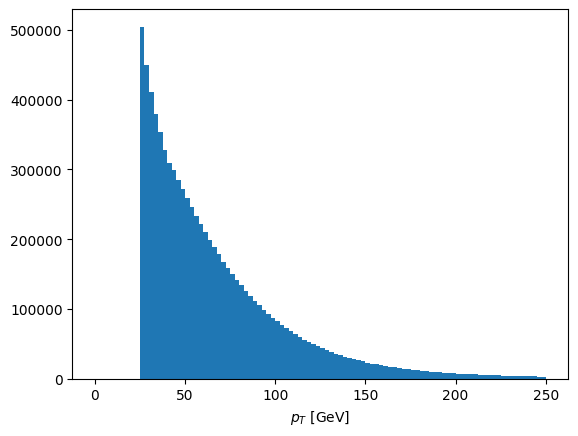

In [8]:
plt.hist(ak.flatten(jet_data_dask.pt).compute(), bins=100, range=(0, 250))
plt.xlabel("$p_T$ [GeV]")
plt.show()

In [9]:
jets_count = ak.count(jet_data_dask.pt, axis=-1).compute()

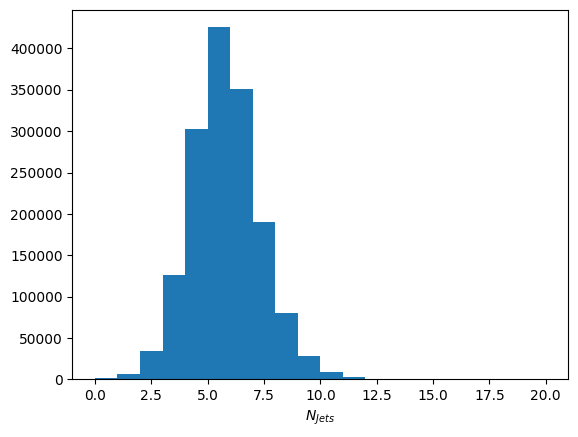

In [10]:
plt.hist(jets_count, bins=20, range=(0, 20))
plt.xlabel("$N_{Jets}$")
plt.show()

## Using a local Run

A few things:

* `docker` must be installed locally
* `docker` must be running! You'll get a very odd error from `docker` that isn't indicative that it isn't running if it isn't. And this error won't happen until you actually try to `value()` your expression.

This file was made local using the following `rucio`:

```python

```


In [11]:
from func_adl_servicex import SXLocalxAOD
from func_adl_servicex_xaodr22.event_collection import Event
from func_adl_servicex_xaodr22 import atlas_release, calib_tools
print (atlas_release)

from pathlib import Path
import awkward as ak
import matplotlib.pyplot as plt

22.2.113


In [12]:
class xAODLocalTyped(SXLocalxAOD[Event]):
    def __init__(self, file_path: Path):
        super().__init__(
            file_path,
            item_type=Event,
            docker_image="gitlab-registry.cern.ch/atlas/athena/analysisbase",
            docker_tag=atlas_release,
        )


In [13]:
dataset_path = Path(r"C:\Users\gordo\Code\atlas\data\R24\601237.PhPy8EG_A14_ttbar_hdamp258p75_allhad_PHYSLITE\DAOD_PHYSLITE.35040212._000001.pool.root.1")
assert dataset_path.exists()

With that hand-coded infrastructure out of the way, we can now operate on the local file as if it was a normal SX dataset.

* Ignore the backend warnings with the next line - there really isn't a backend involved for the local running.

In [14]:
ds = xAODLocalTyped(dataset_path)
ds = calib_tools.query_update(
    ds, calib_config=calib_tools.default_config("PHYSLITE")
)

Found backend type matching "xaod". Matching by type is deprecated. Please switch to using the "name" keyword in your servicex.yaml file.
Found backend type matching "xaod". Matching by type is deprecated. Please switch to using the "name" keyword in your servicex.yaml file.


In [15]:
good_jets = ds.Select(
    lambda e: {
        "run": e.EventInfo("EventInfo").runNumber(),
        "event": e.EventInfo("EventInfo").eventNumber(),
        "good_jets": e.Jets()
                     .Where(lambda j: (j.pt() / 1000 > 25.0) and (abs(j.eta()) < 2.5)),
    }
)

In [16]:
jet_pt = good_jets.Select(lambda e: {
    "run": e.run,
    "event": e.event,
    "pt": e.good_jets.Select(lambda ele: ele.pt() / 1000.0),
}).AsAwkwardArray()

In [17]:
jet_data_dask = jet_pt.value()

In [18]:
jet_data_dask.pt.compute()

<Array [[67.6, 61.3, 52.3, 32.2], ..., [...]] type='10000 * var * float64'>

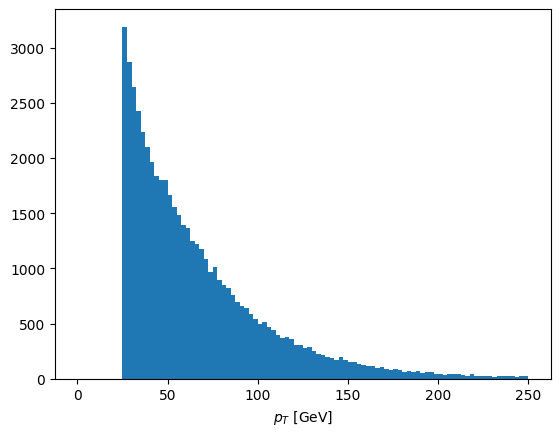

In [19]:
plt.hist(ak.flatten(jet_data_dask.pt).compute(), bins=100, range=(0, 250))
plt.xlabel("$p_T$ [GeV]")
plt.show()

In [20]:
jets_count = ak.count(jet_data_dask.pt, axis=-1).compute()

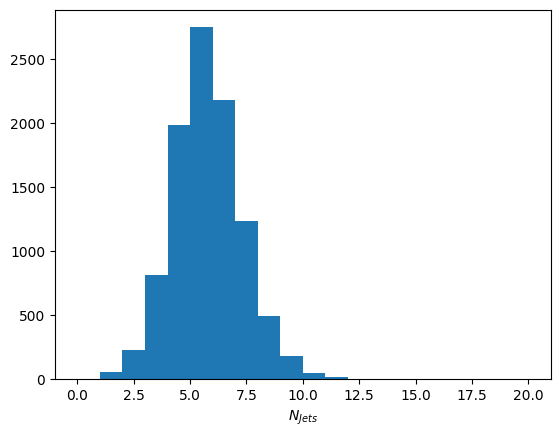

In [21]:
plt.hist(jets_count, bins=20, range=(0, 20))
plt.xlabel("$N_{Jets}$")
plt.show()